In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Load PaDEL data and make train, test set


In [2]:
filepath = '../data/CheMBL_data_all_PaDEL.csv'
df = pd.read_csv(filepath)
df['class'] = df['class'].astype('category')
df['label'] = df['class'].cat.codes
df2 = df.copy()
df2 = df2.drop(['molecule_chembl_id','canonical_smiles','standard_value','class'], axis=1)
X = df2.drop(['label'], axis=1)
y = df2['label'].astype("category")
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 123, stratify=y)

In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((334, 881), (59, 881), (334,), (59,))

In [4]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


(array([0, 1]), array([ 84, 250]))
(array([0, 1]), array([15, 44]))


In [5]:
X_train_np = np.asarray(X_train).astype(np.float32) 
X_test_np = np.asarray(X_test).astype(np.float32) 

In [6]:
# prepare labels for Neural Network

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
def prepare_targets(y_train, y_test):
	y_train_enc = np_utils.to_categorical(y_train)
	y_test_enc = np_utils.to_categorical(y_test)
	return y_train_enc, y_test_enc

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


2022-12-21 13:36:46.082143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build Neural Network Model

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D , MaxPool2D , Flatten , Dropout, concatenate, Concatenate, Add
import tensorflow as tf
import keras

In [8]:
def baseModel1(input_data):
  hidden1 = Input(shape=input_data.shape[1])
  hidden31 = Dense(2048, activation='relu')(hidden1)

  hidden3 = Dropout(0.5)(hidden31)
  hidden32 = Dense(4096, activation='relu')(hidden3)

  #c1 = Concatenate()([hidden31, hidden32])

  hidden3 = Dropout(0.2)(hidden32)
  hidden33 = Dense(1024, activation='relu')(hidden3)

  #c2 = Concatenate()([ hidden32, hidden33])

  #hidden3 = Dropout(0.2)(c2)
  hidden34 = Dense(512, activation='relu')(hidden33)

  #c3 = Concatenate()([ hidden33, hidden34])

  #hidden3 = Dropout(0.2)(c3)
  hidden35 = Dense(256, activation='relu')(hidden34)

  #c4 = Concatenate()([ hidden34, hidden35])

  hidden36 = Dense(128, activation='relu')(hidden35) 

  

  x = Dense(2, activation='softmax')(hidden36)
  
  model = Model(inputs=hidden1, outputs=x)
  return model

In [9]:
model = baseModel1(X_train)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[
                tf.keras.metrics.BinaryAccuracy(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.FalseNegatives()])
model.summary()

2022-12-21 13:37:00.868342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 881)]             0         
                                                                 
 dense (Dense)               (None, 2048)              1806336   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_3 (Dense)             (None, 512)               524800

In [15]:

checkpoint = keras.callbacks.ModelCheckpoint(filepath='saved_model/my_best_model.epoch{epoch:02d}-acc{val_binary_accuracy:.2f}.hdf5', 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callback_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=40),
                  checkpoint,
                  #tf.keras.callbacks.TensorBoard(log_dir='./logs')
]


In [16]:

history = model.fit(
    x=X_train_np,
    y=y_train_enc,
    batch_size=16,
    epochs=120,
    verbose='auto',
    callbacks= callback_list,
    validation_data= (X_test_np, y_test_enc)
)

Epoch 1/120
21/21 [==============================] - ETA: 0s - loss: 0.3206 - binary_accuracy: 0.8563 - false_positives: 48.0000 - false_negatives: 48.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.79661, saving model to saved_model/my_best_model.epoch01-acc0.80.hdf5
21/21 [==============================] - 3s 153ms/step - loss: 0.3206 - binary_accuracy: 0.8563 - false_positives: 48.0000 - false_negatives: 48.0000 - val_loss: 0.6841 - val_binary_accuracy: 0.7966 - val_false_positives: 12.0000 - val_false_negatives: 12.0000
Epoch 2/120
21/21 [==============================] - ETA: 0s - loss: 0.2750 - binary_accuracy: 0.8952 - false_positives: 35.0000 - false_negatives: 35.0000
Epoch 2: val_binary_accuracy improved from 0.79661 to 0.83051, saving model to saved_model/my_best_model.epoch02-acc0.83.hdf5
21/21 [==============================] - 3s 151ms/step - loss: 0.2750 - binary_accuracy: 0.8952 - false_positives: 35.0000 - false_negatives: 35.0000 - val_loss: 0.6394 - val_bin

2/2 [==============================] - 0s 14ms/step


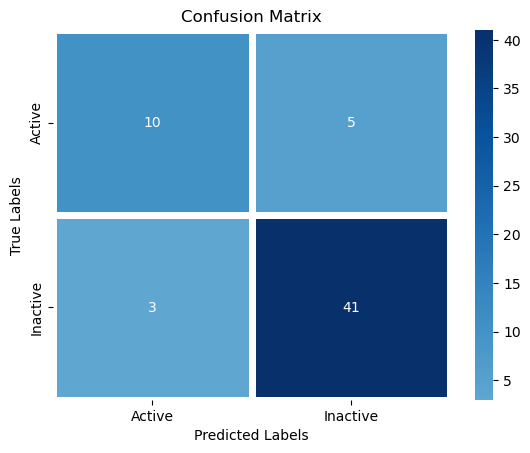

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.89      0.93      0.91        44

    accuracy                           0.86        59
   macro avg       0.83      0.80      0.81        59
weighted avg       0.86      0.86      0.86        59



In [17]:
loaded_2 = tf.keras.models.load_model("saved_model/my_best_model.epoch28-acc0.86.hdf5")

y_pred_val = loaded_2.predict(X_test)

y_pred_class = np.argmax(y_pred_val, axis=1)

y_test_class = np.argmax(y_test_enc, axis=1)

from numpy.testing._private.utils import nulp_diff
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


cf_matrix = confusion_matrix(y_test_class, y_pred_class)
#sns.heatmap(cf_matrix, annot=True, cmap='Blues') 

ax = plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='d', ax=ax, linewidths=5, cmap="Blues", center=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Active', 'Inactive'])
ax.yaxis.set_ticklabels(['Active', 'Inactive'])
plt.show()

print(classification_report(y_test_class, y_pred_class))


In [18]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'false_positives', 'false_negatives', 'val_loss', 'val_binary_accuracy', 'val_false_positives', 'val_false_negatives'])

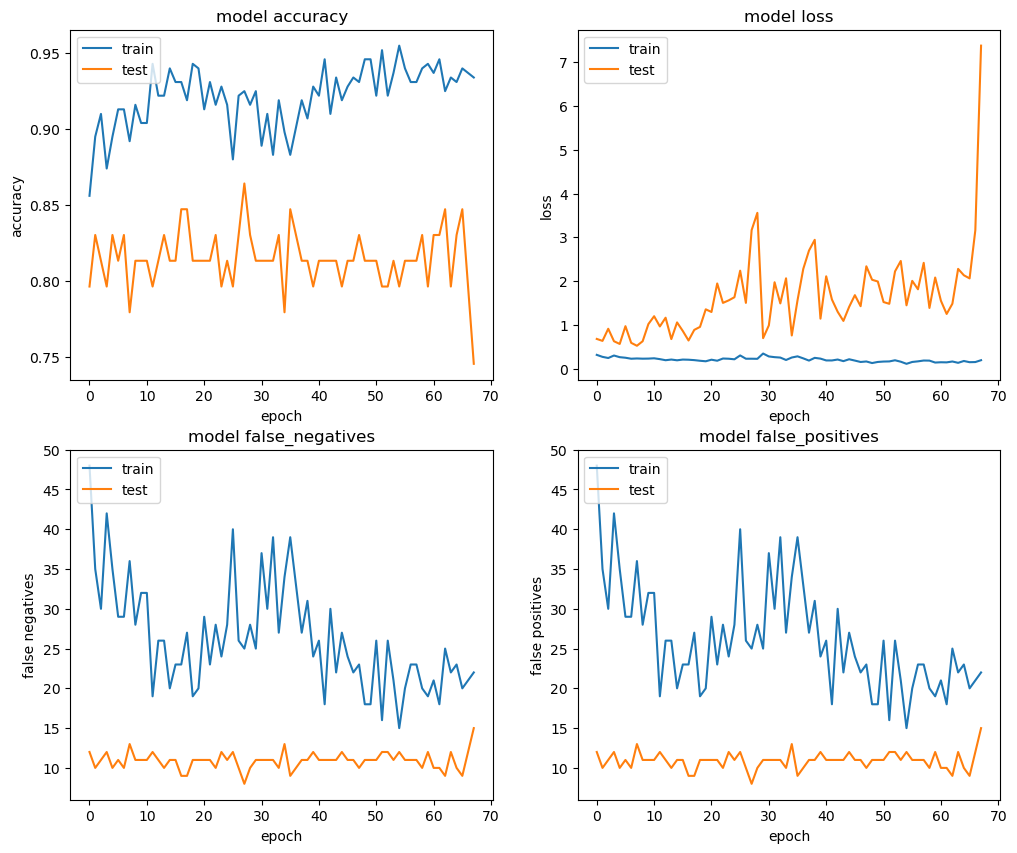

In [19]:
metrics = list(history.history.keys())
fig = plt.figure(figsize=(12,10))
# summarize history for accuracy
plt.subplot(2,2,1)
plt.plot(history.history[metrics[1]])
plt.plot(history.history[metrics[5]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.subplot(2,2,2)
plt.plot(history.history[metrics[0]])
plt.plot(history.history[metrics[4]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for false_negatives
plt.subplot(2,2,3)
plt.plot(history.history[metrics[3]])
plt.plot(history.history[metrics[7]])
plt.title('model false_negatives')
plt.ylabel('false negatives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()

# summarize history for false_positives
plt.subplot(2,2,4)
plt.plot(history.history[metrics[2]])
plt.plot(history.history[metrics[6]])
plt.title('model false_positives')
plt.ylabel('false positives')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()